<a href="https://colab.research.google.com/github/LinoVation1312/test/blob/main/TP1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, mixed_precision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import itertools


#  Constantes

In [13]:
BATCH_SIZE = 128
EPOCHS = 20
INIT_LR = 1e-3
WEIGHT_DECAY = 1e-5
WARMUP_EPOCHS = int(EPOCHS * 0.1)

In [5]:
# --- Configuration de la Précision Mixte (pour accélération sur GPU compatibles) ---
# Très utile sur les GPU T4, P100, V100 de Colab
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)



Compute dtype: float16
Variable dtype: float32


In [6]:
# Assurer la reproductibilité
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

#Chargement et Préparation des Données CIFAR-10

In [7]:
# Chargement du dataset CIFAR-10
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Conversion en float32 et normalisation [0, 1]
# Note: la conversion en float32 peut se faire ici ou dans le pipeline tf.data
# Le faire ici est simple. tf.data peut le gérer aussi si nécessaire.
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Séparation en ensembles d'entraînement et de validation
# Utilisation des 5000 premières images pour la validation
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
X_train_full shape: (50000, 32, 32, 3)
y_train_full shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
X_valid shape: (5000, 32, 32, 3)
y_valid shape: (5000, 1)


#Augmentation des données (transformation des images)

In [8]:
# Fonction d'augmentation des données
def augment_data(image, label):
    # Cast en float32 (nécessaire pour les opérations d'augmentation de tf.image)
    # Même si les données sont déjà en float32, cela garantit le type attendu.
    image = tf.cast(image, tf.float32)

    # --- Augmentations ---
    # Padding puis Random Crop (simule translation et maintient la taille)
    image = tf.image.resize_with_pad(image, 36, 36) # Ajoute 4 pixels de padding
    image = tf.image.random_crop(image, size=[32, 32, 3])

    # Random Flip Left/Right
    image = tf.image.random_flip_left_right(image)

    # Random Brightness/Contrast
    image = tf.image.random_brightness(image, max_delta=0.1) # Ajusté légèrement
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # --- Autres augmentations possibles (à décommenter/ajouter si besoin) ---
    # Rotation (utiliser tfa si besoin d'angles arbitraires)
    # image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # RandAugment (nécessite tensorflow-addons)
    # Assurez-vous que tfa est importé
    # num_augmentations = 2 # Nombre d'opérations à appliquer
    # magnitude = 0.15      # Force des opérations (entre 0 et 1)
    # image = tfa.image.randaugment.randaugment_transform(
    #     image, num_layers=num_augmentations, magnitude=magnitude,
    #     fill_mode='nearest', # ou 'constant'
    # )

    # Cutout / Random Erasing (implémentation manuelle ou via tfa)
    # ...

    # Normalisation (déjà faite, mais si on utilisait des entiers, on normaliserait ici)
    # image = image / 255.0

    return image, label

# Fonction pour créer le dataset tf.data optimisé
def create_dataset(images, labels, is_training=False, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if is_training:
        # Mélanger *avant* l'augmentation et le batching pour l'entraînement
        dataset = dataset.shuffle(images.shape[0]) # Shuffle avec la taille complète du set
        # Appliquer l'augmentation
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

    # Mise en batch
    # drop_remainder=True peut être utile pour l'entraînement si la dernière batch est petite
    dataset = dataset.batch(batch_size, drop_remainder=is_training)

    # Prefetch pour la performance (chevauchement CPU/GPU)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

#Création dataset

In [10]:
train_ds = create_dataset(X_train, y_train, is_training=True)
valid_ds = create_dataset(X_valid, y_valid, is_training=False) # Pas d'augmentation/shuffle pour la validation
test_ds = create_dataset(X_test, y_test, is_training=False)    # Pas d'augmentation/shuffle pour le test

# Afficher un exemple de batch (optionnel)
for images, labels in train_ds.take(1):
    print("Shape des images dans un batch:", images.shape) # (BATCH_SIZE, 32, 32, 3)
    print("Shape des labels dans un batch:", labels.shape) # (BATCH_SIZE, 1)
    print("Type des images:", images.dtype) # Devrait être float16 si mixed precision activée
    print("Type des labels:", labels.dtype)

Shape des images dans un batch: (128, 32, 32, 3)
Shape des labels dans un batch: (128, 1)
Type des images: <dtype: 'float32'>
Type des labels: <dtype: 'uint8'>


#Architecture du Réseau de Neurones

In [11]:
# Bloc résiduel amélioré
def residual_block(x, filters, kernel_size=3, stride=1, use_conv_shortcut=False):
    shortcut = x

    # Initialiseur et Régulariseur communs
    kernel_init = 'he_normal'
    kernel_reg = regularizers.l2(WEIGHT_DECAY)

    # Raccourci (shortcut connection)
    # Appliquer Conv 1x1 si stride > 1 OU si le nombre de filtres change OU si forcé
    if stride != 1 or x.shape[-1] != filters or use_conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same',
                                 kernel_initializer=kernel_init,
                                 kernel_regularizer=kernel_reg)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut) # BN après la conv du shortcut

    # Première convolution du bloc principal
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_initializer=kernel_init,
                      kernel_regularizer=kernel_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Deuxième convolution du bloc principal
    x = layers.Conv2D(filters, kernel_size, padding='same', # Stride est 1 ici
                      kernel_initializer=kernel_init,
                      kernel_regularizer=kernel_reg)(x)
    x = layers.BatchNormalization()(x)

    # Ajout de la connexion résiduelle
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x) # Activation après l'addition (ResNet v1 style)
    return x

# Fonction pour construire le modèle complet
def build_optimized_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    # Couche initiale
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # Pas de max pooling ici pour garder la résolution pour le 1er bloc

    # --- Blocs Résiduels ---
    # Stage 1 (64 filtres)
    # Le premier bloc n'a pas besoin de conv_shortcut car filters=64 et stride=1
    x = residual_block(x, 64, stride=1, use_conv_shortcut=False)
    x = residual_block(x, 64, stride=1, use_conv_shortcut=False) # Ajouter plus de blocs si besoin
    # Pas de downsampling ici, on peut le faire avant le prochain stage

    # Stage 2 (128 filtres) - Downsampling ici (soit par stride=2, soit par Pooling)
    # Option 1: Downsampling via stride dans le 1er bloc du stage
    # x = residual_block(x, 128, stride=2, use_conv_shortcut=True) # shortcut nécessaire car stride=2 et filters change
    # Option 2: Downsampling via MaxPooling (comme dans le code original)
    x = layers.MaxPooling2D(pool_size=2)(x) # Réduit H et W par 2
    x = residual_block(x, 128, stride=1, use_conv_shortcut=True) # shortcut nécessaire car filters change (64->128)
    x = residual_block(x, 128, stride=1, use_conv_shortcut=False)
    x = layers.Dropout(0.1)(x) # Dropout après le stage

    # Stage 3 (256 filtres) - Downsampling
    # Option 1: Stride
    # x = residual_block(x, 256, stride=2, use_conv_shortcut=True)
    # Option 2: Pooling
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = residual_block(x, 256, stride=1, use_conv_shortcut=True) # shortcut car filters change (128->256)
    x = residual_block(x, 256, stride=1, use_conv_shortcut=False)
    x = layers.Dropout(0.2)(x)

    # Stage 4 (512 filtres) - Optionnel, pour plus de profondeur
    # x = layers.MaxPooling2D(pool_size=2)(x)
    # x = residual_block(x, 512, stride=1, use_conv_shortcut=True)
    # x = residual_block(x, 512, stride=1, use_conv_shortcut=False)
    # x = layers.Dropout(0.3)(x)

    # --- Tête de Classification ---
    x = layers.GlobalAveragePooling2D()(x) # Réduit chaque feature map à un seul nombre
    x = layers.Dropout(0.5)(x) # Dropout plus fort avant la couche Dense finale
    x = layers.Dense(256, activation='relu', # Couche Dense intermédiaire (optionnelle mais peut aider)
                     kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    # x = layers.Activation('relu')(x)
    # x = layers.Dropout(0.5)(x) # Un autre Dropout si besoin


    # Couche de sortie - Utiliser dtype='float32' pour la stabilité avec mixed precision
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


#Planning du Taux d'apprentissage

Total Epochs: 20, Warmup Epochs: 2, Initial LR: 0.001


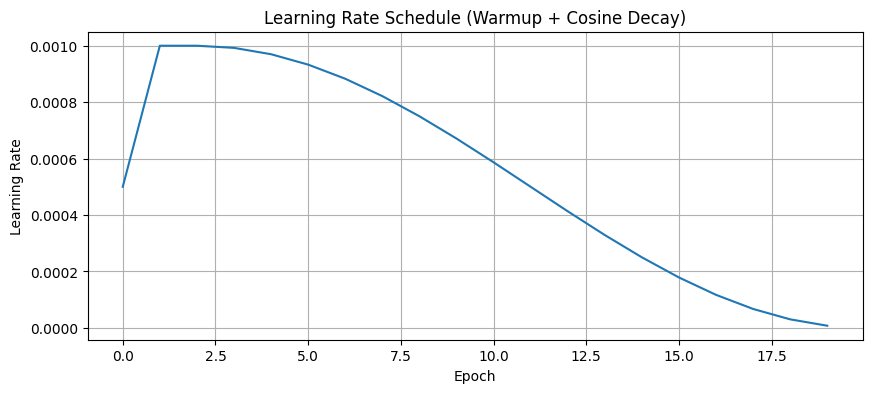

In [14]:
print(f"Total Epochs: {EPOCHS}, Warmup Epochs: {WARMUP_EPOCHS}, Initial LR: {INIT_LR}")

def lr_warmup_cosine_decay_schedule(epoch):
    """ Calcule le LR pour une époque donnée basé sur Warmup + Cosine Decay """
    # Phase Warmup
    if epoch < WARMUP_EPOCHS:
        # Augmentation linéaire de ~0 à INIT_LR
        # Pour éviter LR=0 à l'époque 0, on peut commencer à epoch+1 ou un petit offset
        lr = (INIT_LR / WARMUP_EPOCHS) * (epoch + 1)
    # Phase Cosine Decay
    else:
        # Calcul de la progression dans la phase de decay (de 0 à 1)
        # Assure que la division ne se fait pas par zéro si WARMUP_EPOCHS == EPOCHS
        total_decay_epochs = EPOCHS - WARMUP_EPOCHS
        progress = (epoch - WARMUP_EPOCHS) / total_decay_epochs if total_decay_epochs > 0 else 1.0
        # Formule Cosine Decay
        lr = 0.5 * INIT_LR * (1 + np.cos(np.pi * progress))

    # Ajouter une limite inférieure au LR (optionnel)
    # lr = max(lr, 1e-6)
    return lr

# Visualisation du planning LR (optionnel)
epochs_range = range(EPOCHS)
lrs = [lr_warmup_cosine_decay_schedule(epoch) for epoch in epochs_range]
plt.figure(figsize=(10, 4))
plt.plot(epochs_range, lrs)
plt.title('Learning Rate Schedule (Warmup + Cosine Decay)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

# Construire le modèle

In [16]:
model = build_optimized_model()
#model.summary()

# Optimiseur AdamW

In [18]:
optimizer = keras.optimizers.AdamW(
    learning_rate=INIT_LR, # Le LR initial sera géré par le scheduler
    weight_decay=WEIGHT_DECAY
)

# Compilation du modèle

In [19]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(), # Pour labels entiers (0, 1, ..., 9)
    metrics=['accuracy']
)


#Callbacks

In [20]:

callback_list = [
    # Arrêt anticipé si la val_accuracy ne s'améliore pas pendant 'patience' époques
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15, # Augmenter la patience car le LR diminue lentement
        mode='max',
        restore_best_weights=True, # Garder les meilleurs poids trouvés
        verbose=1
    ),
    # Scheduler de taux d'apprentissage personnalisé
    keras.callbacks.LearningRateScheduler(
        lr_warmup_cosine_decay_schedule,
        verbose=1
    ),
    # Sauvegarde du meilleur modèle basé sur val_accuracy
    keras.callbacks.ModelCheckpoint(
        filepath='best_cifar10_model.keras', # Utiliser l'extension .keras (nouveau format)
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
  ]

#Entraînement du Modèle

In [21]:
print("Début de l'entraînement...")

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=callback_list,
    verbose=1 # Afficher une barre de progression par époque
)

print("Entraînement terminé.")

Début de l'entraînement...

Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3269 - loss: 2.0140
Epoch 1: val_accuracy improved from -inf to 0.47720, saving model to best_cifar10_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 110ms/step - accuracy: 0.3272 - loss: 2.0130 - val_accuracy: 0.4772 - val_loss: 1.5832 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5634 - loss: 1.2724
Epoch 2: val_accuracy improved from 0.47720 to 0.52540, saving model to best_cifar10_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.5635 - loss: 1.2721 - val_accuracy: 0.5254 - val_loss: 1.6235 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6845 - loss: 0.9490
Epoch 3: val_accuracy did not impr

#Evalutaion sur tous les tests

In [24]:
print("\nÉvaluation sur l'ensemble de test:")

print("\nDernier modèle (pas forcément le meilleur) :)")
loss, accuracy = model.evaluate(test_ds, verbose=0)
print(f"Test Loss (modèle final): {loss:.4f}")
print(f"Test Accuracy (modèle final): {accuracy:.4f}")


Évaluation sur l'ensemble de test:

Dernier modèle (pas forcément le meilleur) :)
Test Loss (modèle final): 0.5517
Test Accuracy (modèle final): 0.8624


In [25]:
print("Chargement du meilleur modèle sauvegardé...")
best_model = keras.models.load_model('best_cifar10_model.keras')

print("Évaluation du meilleur modèle sur l'ensemble de test:")
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)
print(f"Test Loss (meilleur modèle): {test_loss:.4f}")
print(f"Test Accuracy (meilleur modèle): {test_accuracy:.4f}")

Chargement du meilleur modèle sauvegardé...
Évaluation du meilleur modèle sur l'ensemble de test:
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8640 - loss: 0.5475
Test Loss (meilleur modèle): 0.5517
Test Accuracy (meilleur modèle): 0.8624


#Visualisation de l'historique de l'entraînement

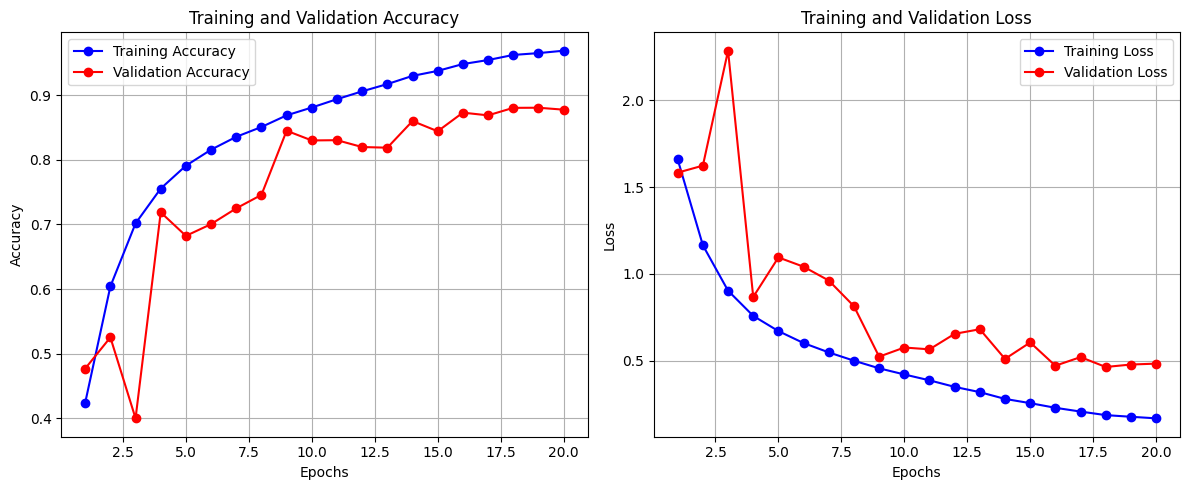

In [26]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Afficher les graphiques
plot_history(history)

#Evalutaion des performances du modèle

In [27]:
y_true = y_test.flatten() # Transforme en (10000,)

# Noms des classes CIFAR-10 pour l'affichage
cifar10_classes = ['Avion', 'Voiture', 'Oiseau', 'Chat', 'Cerf',
                   'Chien', 'Grenouille', 'Cheval', 'Bateau', 'Camion']


In [28]:
print("Génération des prédictions sur l'ensemble de test...")

# Prédiction des probabilités pour chaque classe sur l'ensemble de test
# Utiliser X_test (numpy array normalisé) est souvent plus simple ici
# que d'itérer sur test_ds pour collecter les prédictions
y_pred_probs = best_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

# Obtenir la classe prédite (celle avec la probabilité la plus élevée)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("Prédictions terminées.")
print(f"Nombre de prédictions: {len(y_pred_classes)}")
print(f"Exemple de 10 premières vraies classes : {y_true[:10]}")
print(f"Exemple de 10 premières classes prédites: {y_pred_classes[:10]}")

Génération des prédictions sur l'ensemble de test...
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Prédictions terminées.
Nombre de prédictions: 10000
Exemple de 10 premières vraies classes : [3 8 8 0 6 6 1 6 3 1]
Exemple de 10 premières classes prédites: [3 8 8 0 6 6 1 6 3 1]


#Rapport de classification

In [29]:

print("="*70)
print("             RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("="*70)

# Calculer et afficher le rapport (précision, rappel, f1-score par classe)
report = classification_report(y_true, y_pred_classes, target_names=cifar10_classes)
print(report)

print("="*70)

             RAPPORT DE CLASSIFICATION DÉTAILLÉ
              precision    recall  f1-score   support

       Avion       0.87      0.89      0.88      1000
     Voiture       0.94      0.97      0.95      1000
      Oiseau       0.79      0.86      0.82      1000
        Chat       0.77      0.70      0.73      1000
        Cerf       0.81      0.87      0.84      1000
       Chien       0.92      0.64      0.75      1000
  Grenouille       0.77      0.95      0.85      1000
      Cheval       0.94      0.88      0.91      1000
      Bateau       0.90      0.95      0.93      1000
      Camion       0.96      0.91      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



In [39]:
# Get a list of all colormap names
#cmaps = plt.colormaps()

# Print the list
#print("Tous les noms de colormaps disponibles dans Matplotlib :")
#for cmap in cmaps:
    #print(cmap)


Tous les noms de colormaps disponibles dans Matplotlib :
magma
inferno
plasma
viridis
cividis
twilight
twilight_shifted
turbo
berlin
managua
vanimo
Blues
BrBG
BuGn
BuPu
CMRmap
GnBu
Greens
Greys
OrRd
Oranges
PRGn
PiYG
PuBu
PuBuGn
PuOr
PuRd
Purples
RdBu
RdGy
RdPu
RdYlBu
RdYlGn
Reds
Spectral
Wistia
YlGn
YlGnBu
YlOrBr
YlOrRd
afmhot
autumn
binary
bone
brg
bwr
cool
coolwarm
copper
cubehelix
flag
gist_earth
gist_gray
gist_heat
gist_ncar
gist_rainbow
gist_stern
gist_yarg
gnuplot
gnuplot2
gray
hot
hsv
jet
nipy_spectral
ocean
pink
prism
rainbow
seismic
spring
summer
terrain
winter
Accent
Dark2
Paired
Pastel1
Pastel2
Set1
Set2
Set3
tab10
tab20
tab20b
tab20c
grey
gist_grey
gist_yerg
Grays
magma_r
inferno_r
plasma_r
viridis_r
cividis_r
twilight_r
twilight_shifted_r
turbo_r
berlin_r
managua_r
vanimo_r
Blues_r
BrBG_r
BuGn_r
BuPu_r
CMRmap_r
GnBu_r
Greens_r
Greys_r
OrRd_r
Oranges_r
PRGn_r
PiYG_r
PuBu_r
PuBuGn_r
PuOr_r
PuRd_r
Purples_r
RdBu_r
RdGy_r
RdPu_r
RdYlBu_r
RdYlGn_r
Reds_r
Spectral_r
Wistia_r
Yl

#Matrice de confusion


                  MATRICE DE CONFUSION
Matrice de Confusion (Nombre d'images) :

Pred:  Avi  Voi  Ois  Cha  Cer  Chi  Gre  Che  Bat  Cam
-------------------------------------------------------
True: Avi   894   5  37   4   6   0   3   2  42   7
True: Voi     6 966   0   1   3   0   2   0   9  13
True: Ois    26   0 856  17  30   4  57   6   3   1
True: Cha    27   5  59 704  62  39  72  11  16   5
True: Cer     6   1  39  10 869   1  64   8   1   1
True: Chi     9   2  50 154  47 638  62  31   6   1
True: Gre     7   0  17  10   7   1 954   1   2   1
True: Che    16   1  19  11  47  10  11 882   3   0
True: Bat    25   6   2   3   0   0   3   0 953   8
True: Cam    15  42   2   3   2   0   5   0  23 908




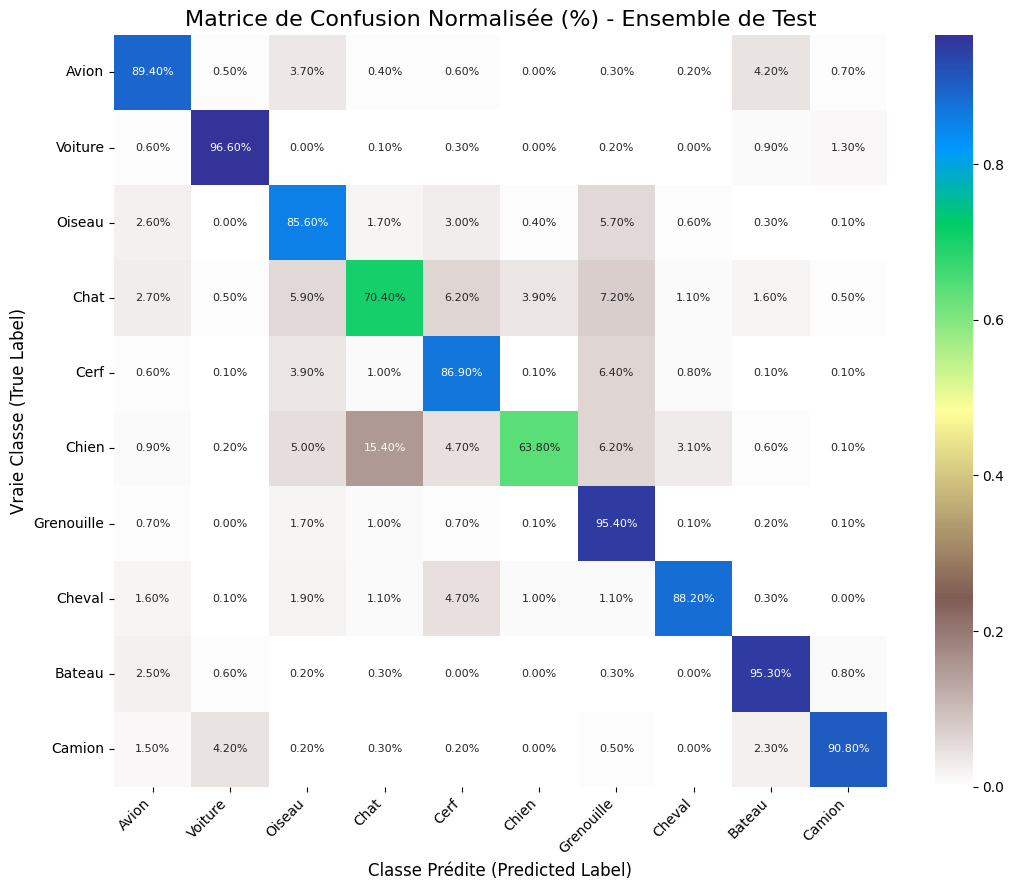

In [43]:
print("\n" + "="*70)
print("                  MATRICE DE CONFUSION")
print("="*70)

# Calculer la matrice de confusion (valeurs absolues)
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher les valeurs absolues pour référence
print("Matrice de Confusion (Nombre d'images) :\n")
# Affichage formaté des valeurs brutes (optionnel mais utile)
header = "Pred: " + " ".join([f"{cls[:3]:>4}" for cls in cifar10_classes])
print(header)
print("-" * len(header))
for i, row in enumerate(cm):
    row_str = "".join([f"{val:4d}" for val in row])
    print(f"True: {cifar10_classes[i][:3]:<4} {row_str}")
print("\n" + "="*70 + "\n")


# Calculer la matrice de confusion normalisée par rapport aux vraies classes (lignes)
# Chaque ligne somme à 1 (ou 100%)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Afficher la matrice de confusion normalisée avec Seaborn heatmap
plt.figure(figsize=(11, 9)) # Légèrement plus grand pour les pourcentages
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='terrain_r', # Format '.2%' pour pourcentage
            xticklabels=cifar10_classes, yticklabels=cifar10_classes,
            annot_kws={"size": 8}) # Réduire taille police si besoin

plt.title('Matrice de Confusion Normalisée (%) - Ensemble de Test', fontsize=16)
plt.ylabel('Vraie Classe (True Label)', fontsize=12)
plt.xlabel('Classe Prédite (Predicted Label)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("="*70)

#Erreurs de prédiction


           EXEMPLES D'IMAGES MAL CLASSIFIÉES


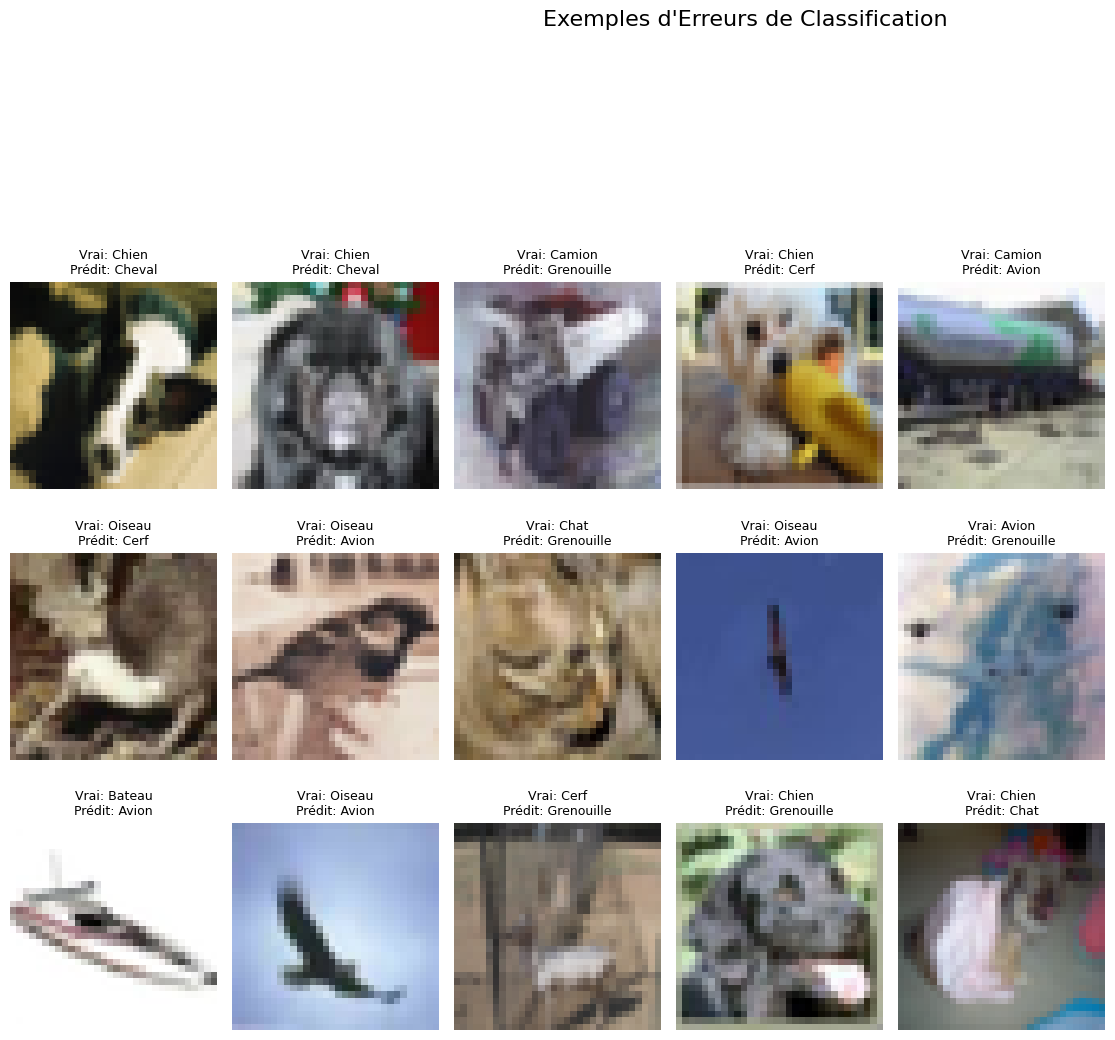

In [34]:

print("\n" + "="*70)
print("           EXEMPLES D'IMAGES MAL CLASSIFIÉES")
print("="*70)

# Trouver les indices des images mal classifiées
misclassified_idx = np.where(y_pred_classes != y_true)[0]

# Sélectionner quelques exemples aléatoires parmi les erreurs
num_examples_to_show = 15
if len(misclassified_idx) > num_examples_to_show:
    selected_idx = np.random.choice(misclassified_idx, num_examples_to_show, replace=False)
else:
    selected_idx = misclassified_idx # Montrer toutes les erreurs si moins de 15

if len(selected_idx) == 0:
     print("Incroyable ! Aucune erreur de classification trouvée sur cet échantillon !")
else:
    # Afficher les images
    plt.figure(figsize=(15, 5 + (num_examples_to_show // 5) * 3)) # Ajuster la taille dynamiquement
    plt.suptitle("Exemples d'Erreurs de Classification", fontsize=16)
    for i, idx in enumerate(selected_idx):
        plt.subplot( (num_examples_to_show // 5) + 1 , 5, i + 1) # Grille de 5 colonnes
        # Afficher l'image originale (X_test contient les données normalisées [0,1])
        plt.imshow(X_test[idx])
        true_label = cifar10_classes[y_true[idx]]
        pred_label = cifar10_classes[y_pred_classes[idx]]
        plt.title(f"Vrai: {true_label}\nPrédit: {pred_label}", fontsize=9)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 0.75, 0.85]) # Ajuster pour le suptitle
    plt.show()

print("="*70)


        PRÉCISION PAR CLASSE (RAPPEL) & TOP CONFUSIONS


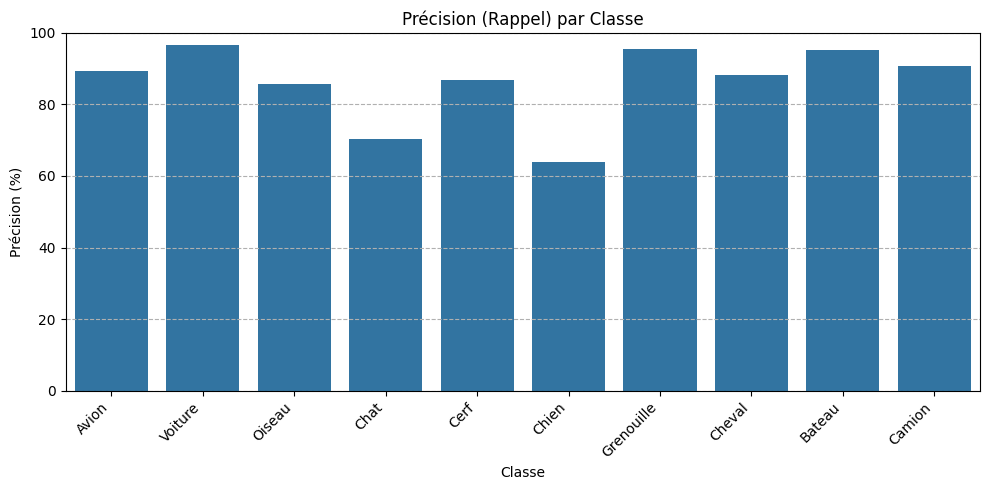


----------------------------------------
     Top Confusions (Vrai -> Prédit)
----------------------------------------
Vraie Classe -> Classe Prédite  | Nombre
----------------------------------------
Chien        -> Chat            | 154   
Chat         -> Grenouille      | 72    
Cerf         -> Grenouille      | 64    
Chien        -> Grenouille      | 62    
Chat         -> Cerf            | 62    
Chat         -> Oiseau          | 59    
Oiseau       -> Grenouille      | 57    
Chien        -> Oiseau          | 50    
Cheval       -> Cerf            | 47    
Chien        -> Cerf            | 47    



In [35]:
print("\n" + "="*70)
print("        PRÉCISION PAR CLASSE (RAPPEL) & TOP CONFUSIONS")
print("="*70)

# --- Précision par classe (Diagonale de la matrice normalisée) ---
per_class_accuracy = cm_normalized.diagonal()

plt.figure(figsize=(10, 5))
sns.barplot(x=cifar10_classes, y=per_class_accuracy * 100) # en pourcentage
plt.title('Précision (Rappel) par Classe')
plt.ylabel('Précision (%)')
plt.xlabel('Classe')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # Axe Y de 0 à 100%
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# --- Top N Confusions ---
print("\n" + "-"*40)
print("     Top Confusions (Vrai -> Prédit)")
print("-"*40)

# Mettre la diagonale à zéro pour ignorer les bonnes classifications
np.fill_diagonal(cm, 0)

# Trouver les indices des N plus grandes valeurs hors diagonale
N = 10 # Nombre de top confusions à afficher
flat_indices = np.argsort(cm.flatten())[::-1] # Indices triés du plus grand au plus petit

confusions = []
for idx in flat_indices[:N]:
    true_idx, pred_idx = np.unravel_index(idx, cm.shape)
    count = cm[true_idx, pred_idx]
    if count == 0: # Arrêter si on a épuisé les confusions non nulles
        break
    confusions.append((cifar10_classes[true_idx], cifar10_classes[pred_idx], count))

# Afficher les confusions
if not confusions:
    print("Aucune confusion trouvée !")
else:
    print(f"{'Vraie Classe':<12} -> {'Classe Prédite':<15} | {'Nombre':<6}")
    print("-" * 40)
    for true_cls, pred_cls, count in confusions:
        print(f"{true_cls:<12} -> {pred_cls:<15} | {count:<6}")

# Remettre la diagonale de cm à sa valeur initiale si cm est réutilisé plus tard
# (Non nécessaire ici, mais bonne pratique si on continue l'analyse avec cm)
# cm = confusion_matrix(y_true, y_pred_classes) # Recalculer si besoin

print("\n" + "="*70)


              COURBES ROC & AIRE SOUS LA COURBE (AUC) - One-vs-Rest


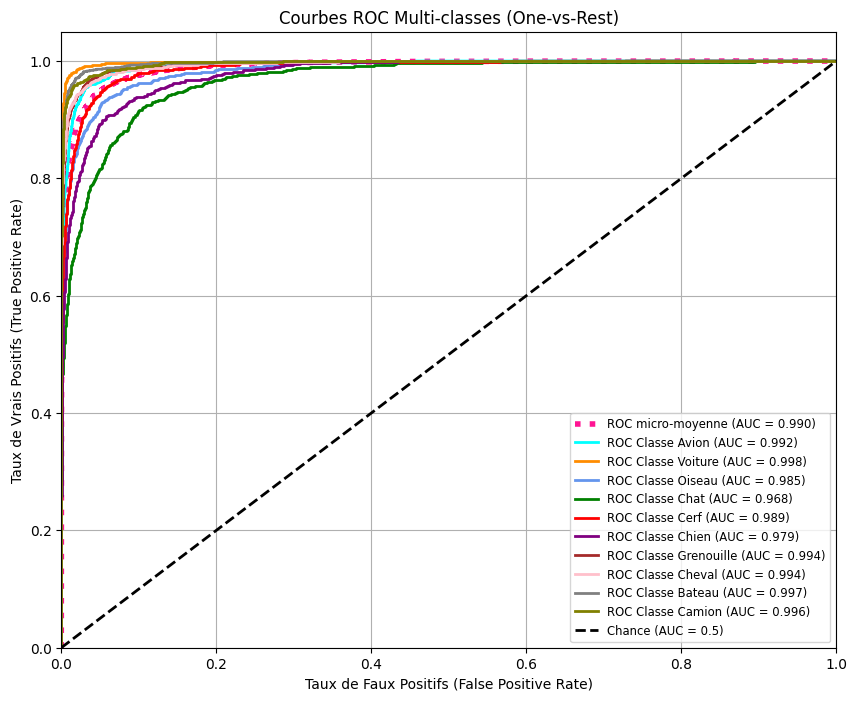


AUC par classe (One-vs-Rest):
- Classe Avion     : 0.9921
- Classe Voiture   : 0.9982
- Classe Oiseau    : 0.9850
- Classe Chat      : 0.9684
- Classe Cerf      : 0.9885
- Classe Chien     : 0.9789
- Classe Grenouille: 0.9936
- Classe Cheval    : 0.9943
- Classe Bateau    : 0.9965
- Classe Camion    : 0.9963

AUC Micro-Moyenne: 0.9897



In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

print("\n" + "="*70)
print("              COURBES ROC & AIRE SOUS LA COURBE (AUC) - One-vs-Rest")
print("="*70)

# Binariser les vrais labels pour l'approche One-vs-Rest
y_true_bin = label_binarize(y_true, classes=range(len(cifar10_classes)))
n_classes = y_true_bin.shape[1]

# Calculer la courbe ROC et l'AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculer la courbe ROC micro-moyenne et l'AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Affichage des Courbes ROC ---
plt.figure(figsize=(10, 8))

# Tracer la courbe micro-moyenne
plt.plot(fpr["micro"], tpr["micro"],
         label=f'ROC micro-moyenne (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=4)

# Tracer la courbe ROC pour chaque classe
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC Classe {cifar10_classes[i]} (AUC = {roc_auc[i]:.3f})')

# Tracer la ligne de référence (pas de compétence)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (False Positive Rate)')
plt.ylabel('Taux de Vrais Positifs (True Positive Rate)')
plt.title('Courbes ROC Multi-classes (One-vs-Rest)')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()

# Afficher les AUC par classe
print("\nAUC par classe (One-vs-Rest):")
for i in range(n_classes):
    print(f"- Classe {cifar10_classes[i]:<10}: {roc_auc[i]:.4f}")
print(f"\nAUC Micro-Moyenne: {roc_auc['micro']:.4f}")


print("\n" + "="*70)

#analyse de la courbe roc

Globalement, on a des prédictions fiables, le modèle est quand même plutôt bien entraîné!


           ANALYSE DE LA CONFIANCE DES PRÉDICTIONS
Confiance moyenne (Correctes):   0.957
Confiance médiane (Correctes):  1.000
Confiance moyenne (Incorrectes): 0.725
Confiance médiane (Incorrectes):0.743


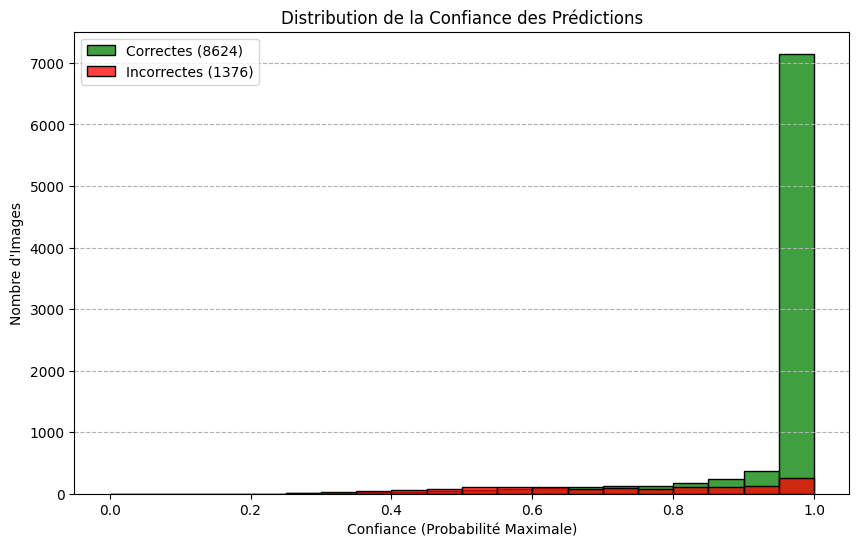

In [37]:
# --- Cellule 18 : Analyse de la Confiance des Prédictions ---

print("\n" + "="*70)
print("           ANALYSE DE LA CONFIANCE DES PRÉDICTIONS")
print("="*70)

# Obtenir la confiance (probabilité maximale) pour chaque prédiction
confidences = np.max(y_pred_probs, axis=1)

# Séparer les confiances pour les prédictions correctes et incorrectes
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

correct_confidences = confidences[correct_indices]
incorrect_confidences = confidences[incorrect_indices]

# Afficher des statistiques
if len(correct_confidences) > 0:
  print(f"Confiance moyenne (Correctes):   {np.mean(correct_confidences):.3f}")
  print(f"Confiance médiane (Correctes):  {np.median(correct_confidences):.3f}")
if len(incorrect_confidences) > 0:
  print(f"Confiance moyenne (Incorrectes): {np.mean(incorrect_confidences):.3f}")
  print(f"Confiance médiane (Incorrectes):{np.median(incorrect_confidences):.3f}")


# --- Affichage des Histogrammes de Confiance ---
plt.figure(figsize=(10, 6))

# Utiliser des bins partagés pour une meilleure comparaison
bins = np.linspace(0, 1, 21) # 20 bins de 0.05 de largeur

if len(correct_confidences) > 0:
  sns.histplot(correct_confidences, bins=bins, kde=False, color='green', label=f'Correctes ({len(correct_confidences)})', stat='count') # ou stat='density'

if len(incorrect_confidences) > 0:
  sns.histplot(incorrect_confidences, bins=bins, kde=False, color='red', label=f'Incorrectes ({len(incorrect_indices)})', stat='count') # ou stat='density'


plt.title('Distribution de la Confiance des Prédictions')
plt.xlabel('Confiance (Probabilité Maximale)')
plt.ylabel('Nombre d\'Images')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

print("\n" + "="*70)